In [1]:
import numpy as np
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,VotingClassifier
from sklearn.linear_model import SGDRegressor, LinearRegression, BayesianRidge, Lasso, HuberRegressor, ElasticNetCV
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
sns.set(color_codes=True)
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import xgboost as xgb
import lightgbm as lgb
np.random.seed(25)

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0


In [4]:
train['var2'].value_counts()

A    25239
C     1040
B      217
Name: var2, dtype: int64

In [5]:
train.dtypes

ID                           int64
datetime                    object
temperature                float64
var1                       float64
pressure                   float64
windspeed                  float64
var2                        object
electricity_consumption    float64
dtype: object

In [6]:
train.isnull().sum(axis=0)

ID                         0
datetime                   0
temperature                0
var1                       0
pressure                   0
windspeed                  0
var2                       0
electricity_consumption    0
dtype: int64

In [7]:
train = train.fillna({"temperature": train["temperature"].mean(), "pressure": train["pressure"].mean(),
                     "windspeed": train["windspeed"].mean(), "var1": train["var1"].mean()})
test = test.fillna({"temperature": test["temperature"].mean(), "pressure": train["pressure"].mean(),
                     "windspeed": test["windspeed"].mean(), "var1": test["var1"].mean()})

# Feature Engineering

In [8]:
def get_month(x):
    txt = str(x)
    date = txt.split(' ')
    y = date[0].split('-')
    if len(y) != 3:
        return 'None'
    return int(y[1])

def get_year(x):
    txt = str(x)
    date = txt.split(' ')
    y = date[0].split('-')
    if len(y) != 3:
        return 'None'
    return int(y[0])

def get_time(x):
    txt = str(x)
    date = txt.split(' ')
    y = date[1].split(':')
    if len(y) != 3:
        return 'None'
    return int(y[0])

In [9]:
train['MONTH'] = train['datetime'].map(lambda x: get_month(x))
train['YEAR'] = train['datetime'].map(lambda x: get_year(x))
train['HOUR'] = train['datetime'].map(lambda x: get_time(x))

test['MONTH'] = test['datetime'].map(lambda x: get_month(x))
test['YEAR'] = test['datetime'].map(lambda x: get_year(x))
test['HOUR'] = test['datetime'].map(lambda x: get_time(x))

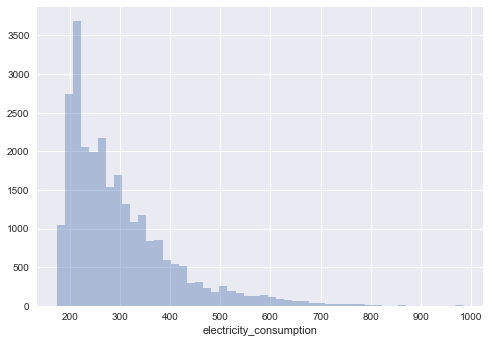

In [18]:
sns.distplot(train['electricity_consumption'] , kde=False);

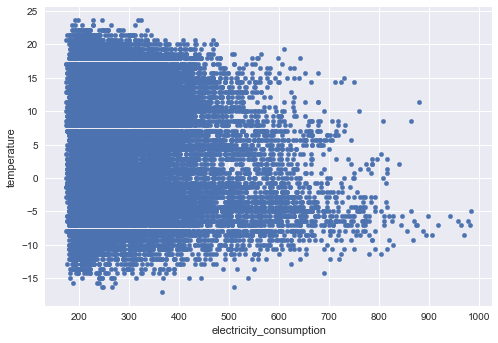

In [17]:
var = 'electricity_consumption'
data = pd.concat([train['temperature'], train[var]], axis=1)
data.plot.scatter(x=var, y='temperature');        # ylim=(0,2500)

In [12]:
# Remove Outlier
train = train[train['electricity_consumption'] < 1000]
train.shape

(26480, 11)

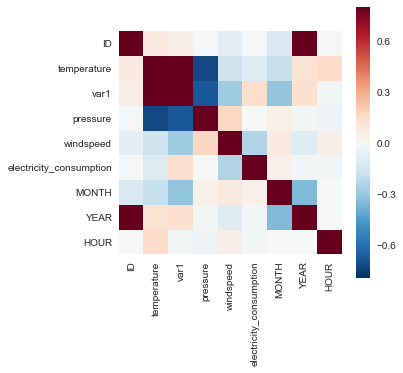

In [13]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corrmat, vmax=.8, square=True);

In [14]:
feature_names = [x for x in train.columns if x not in ['ID','electricity_consumption','datetime']]
target = train['electricity_consumption']

In [15]:
train[feature_names].dtypes

temperature    float64
var1           float64
pressure       float64
windspeed      float64
var2            object
MONTH            int64
YEAR             int64
HOUR             int64
dtype: object

In [16]:
np.arange(len(feature_names))

array([0, 1, 2, 3, 4, 5, 6, 7])

In [13]:
# Current best
from catboost import CatBoostRegressor

model_catboost = CatBoostRegressor(eval_metric='RMSE',learning_rate=0.3,verbose=True, iterations=800,depth=16)

model_catboost.fit(train[feature_names], target, cat_features=[4,5,6,7])

pred = model_catboost.predict(test[feature_names])

pred[:10]

/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module '_catboost' does not match runtime version 3.6
  return f(*args, **kwds)


Borders generated
0:	learn 234.3637751passed: 0.0829 sec	total: 257ms	remaining: 25.4s
1:	learn 180.7377162passed: 0.0109 sec	total: 269ms	remaining: 13.2s
2:	learn 144.1983076passed: 0.0192 sec	total: 289ms	remaining: 9.34s
3:	learn 121.98774passed: 0.0282 sec	total: 318ms	remaining: 7.62s
4:	learn 109.2031162passed: 0.0263 sec	total: 345ms	remaining: 6.55s
5:	learn 101.3440569passed: 0.0306 sec	total: 376ms	remaining: 5.89s
6:	learn 96.80332658passed: 0.23 sec	total: 606ms	remaining: 8.05s
7:	learn 95.17646401passed: 0.00819 sec	total: 615ms	remaining: 7.08s
8:	learn 93.88988232passed: 0.0158 sec	total: 632ms	remaining: 6.39s
9:	learn 93.16556578passed: 0.0165 sec	total: 649ms	remaining: 5.84s
10:	learn 92.23686721passed: 1.65 sec	total: 2.3s	remaining: 18.6s
11:	learn 91.80839033passed: 0.0296 sec	total: 2.33s	remaining: 17.1s
12:	learn 91.1897005passed: 1.55 sec	total: 3.88s	remaining: 26s
13:	learn 90.85163599passed: 0.184 sec	total: 4.07s	remaining: 25s
14:	learn 90.61063367passe

array([ 213.06299399,  207.7613398 ,  205.0391208 ,  210.86940204,
        265.90029014,  252.19321748,  408.90039776,  279.17048392,
        260.46591356,  302.22317087])

In [14]:
## make submission
sub = pd.DataFrame()
sub['ID'] = test['ID']
sub['electricity_consumption'] = pred
sub.to_csv('result.csv', index=False)